# DAB-SMOTE STATISTICAL BENCHMARK EVALUATION #
## Authors: Unai Lalana Morales & José Antonio Sanz Delgado ##

### Imports ###

In [9]:
#Sistem imports
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..\..', 'classes')))

#Local imports
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from statds.no_parametrics import friedman_aligned_ranks, holm
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
import DAB_SMOTE
from dataset import dataReading

### Functions ###

In [38]:
import math
from statds.no_parametrics import stats
def wilconxon(dataset: pd.DataFrame, alpha: float = 0.1, verbose: bool = False):
    """
    Perform the Wilcoxon signed-rank test. This non-parametric test is used to compare two related samples, matched
    samples, or repeated measurements on a single sample to assess whether their population mean ranks differ. It is
    an alternative to the paired Student's t-test when the data is not normally distributed.

    Parameters
    ----------
    dataset : pandas.DataFrame
        A DataFrame with exactly two columns, each representing a different condition or time point for the same
        subjects.
    alpha : float, optional
        The significance level for the test. Default is 0.05.
    verbose : bool, optional
        If True, prints the detailed results table.

    Returns
    -------
    w_wilcoxon : float
        The Wilcoxon test statistic, which is the smallest of the sums of the positive and negative ranks.
    p_value : float or None
        The p-value for the hypothesis test (only for large sample sizes, otherwise None).
    cv_alpha_selected : float or None
        The critical value for the test at the specified alpha level (only for small sample sizes, otherwise None).
    hypothesis : str
        A string stating the conclusion of the test based on the test statistic, critical value, or p-value and alpha.

    Note
    ----
    The Wilcoxon signed-rank test makes fewer assumptions than the t-test and is appropriate when the data
    are not normally distributed. It ranks the absolute differences between pairs, then compares these ranks.
    The test is sensitive to ties and has different procedures for small and large sample sizes. For large samples,
    the test statistic is approximately normally distributed, allowing the use of normal approximation for p-value
    calculation.
    """
    if dataset.shape[1] != 2:
        raise "Error: The test only needs two samples"

    results_table = dataset.copy()
    columns = list(dataset.columns)
    differences_results = dataset[columns[0]] - dataset[columns[1]]
    absolute_dif = differences_results.abs()
    absolute_dif = absolute_dif.sort_values()
    results_wilconxon = {"index": [], "dif": [], "rank": [], "R": []}
    rank = 0.0
    tied_ranges = not (len(set(absolute_dif)) == absolute_dif.shape[0])
    for index in absolute_dif.index:
        if math.fabs(0 - absolute_dif[index]) < 1e-10:
            continue
        rank += 1.0
        results_wilconxon["index"] += [index]
        results_wilconxon["dif"] += [differences_results[index]]
        results_wilconxon["rank"] += [rank]
        results_wilconxon["R"] += ["+" if differences_results[index] > 0 else "-"]

    df = pd.DataFrame(results_wilconxon)
    df = df.set_index("index")
    df = df.sort_index()
    results_table = pd.concat([results_table, df], axis=1)

    tie_sum = 0

    if tied_ranges:
        vector = [abs(i) for i in results_table["dif"]]

        counts = {}
        for number in vector:
            try:
                counts[number] = counts[number] + 1
            except KeyError:
                counts[number] = 1

        ranks = results_table["rank"].to_numpy()
        for index, number in enumerate(vector):
            if counts[number] > 1:
                rank_sum = sum(ranks[i] for i, x in enumerate(vector) if x == number)
                average_rank = rank_sum / counts[number]
                for i, x in enumerate(vector):
                    if x == number:
                        ranks[i] = average_rank
        tie_sizes = np.array(list(counts.values()))
        tie_sum = (tie_sizes ** 3 - tie_sizes).sum()

    if verbose:
        print(results_table)

    r_plus = results_table[results_table.R == "+"]["rank"].sum()
    r_minus = results_table[results_table.R == "-"]["rank"].sum()

    w_wilcoxon = min([r_plus, r_minus])
    num_problems = results_table.shape[0] - (results_table.R.isna().sum())
    mean_wilcoxon = (num_problems * (num_problems + 1)) / 4.0

    std_wilcoxon = num_problems * (num_problems + 1) * ((2 * num_problems) + 1)
    std_wilcoxon = math.sqrt(std_wilcoxon / 24.0 - (tie_sum / 48))
    z_wilcoxon = (w_wilcoxon - mean_wilcoxon) / std_wilcoxon

    cv_alpha_selected = stats.get_cv_willcoxon(num_problems, alpha)

    p_value = 2 * stats.get_p_value_normal(z_wilcoxon)

    # if num_problems > 25:
    hypothesis = f"Fail to Reject H0 with alpha = {alpha} (Same distributions)"
    if p_value < alpha:
        hypothesis = f"Reject H0 with alpha = {alpha} (Different distributions)"

    return w_wilcoxon, p_value, cv_alpha_selected, hypothesis, r_plus, r_minus

In [39]:
def highlight_max(row):
    values_to_compare = row[1:]
    maximum = max(values_to_compare)
    is_unique = (values_to_compare == maximum).sum() == 1
    styles = []
    for val in values_to_compare:
        if val == maximum:
            color = 'green' if is_unique else 'orange'
            styles.append(f'background-color: {color}; font-weight: bold;')
        else:
            styles.append('')
    return [''] + styles

In [104]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

def benchmark(root_paths, param_name, methods, fixed_params, alpha=0.05, progress=False):

    global_df_list = []
    methods = ["Not Oversampled"] + methods
    for root_path in root_paths:
        dataframe_names = []
        
        results_per_method = {method: [] for method in methods}

        dirs = [d for d in os.listdir(root_path) if os.path.isdir(os.path.join(root_path, d))]
        
        iterator = tqdm(dirs, desc=f"Processing {root_path}") if progress else dirs

        for paths in iterator:
            complete_path = os.path.join(root_path, paths)
            dataframe_names.append(paths)

            train = []
            test = []
            for file in os.listdir(complete_path):
                if "tra.dat" in file:
                    train_data = dataReading(complete_path + "/" + file)
                    train.append(train_data)
                    suffix = file.replace("tra.dat", "")
                    test_data = dataReading(complete_path + "/" + suffix + "tst.dat")
                    test.append(test_data)
            
            for method in methods:
                f1_scores = []
                for i in range(len(train)):
                    if method == "Not Oversampled":
                        newX = train[i].data
                        newY = train[i].target
                    else:
                        dab = DAB_SMOTE.DAB_SMOTE(**{param_name: method}, **fixed_params)
                        newX, newY = dab.fit_resample(train[i].data, train[i].target)
                    cls = KNeighborsClassifier()
                    cls.fit(newX, newY)
                    predictions = cls.predict(test[i].data)
                    f1_scores.append(f1_score(np.array(test[i].target), predictions, pos_label=0))

                results_per_method[method].append(np.mean(f1_scores))

        df_methods = pd.DataFrame(results_per_method)
        df_methods = pd.concat([pd.DataFrame(dataframe_names, columns=["dataset"]), df_methods], axis=1)

        global_df_list.append(df_methods)

    final_df = pd.concat(global_df_list, ignore_index=True)

    # Friedman statistical test
    if len(methods) > 2 and progress:
        print("\n--- Friedman Test ---")
        rankings, statistic, p_val, critical_value, hypothesis = friedman_aligned_ranks(final_df.iloc[:, 0:])
        print(f"Friedman statistic: {statistic:.4f}, p-value: {p_val:.4g}, Hypothesis: {hypothesis}")
        print(f"Rankings: {rankings}")

        # Holm post-hoc test if Friedman is significant
        if p_val < alpha:
            print("\n--- Holm Post-hoc Test ---")
            control_method = min(rankings, key=rankings.get)
            num_cases = len(final_df.iloc[:, 0:])
            holm_results, figure = holm(rankings, num_cases, alpha, control = control_method, type_rank = "Friedman Aligned Ranks")
            if (holm_results["Adjusted p-value"].values < 0.1).all():
                best_method = control_method
            else:
                comps = holm_results["Adjusted p-value"].values >= alpha
                if comps.any():
                    best_method = holm_results["Comparison"].values[comps][0].split("vs")[-1]
            print(f"Best method according to Holm: {best_method}")

        # Wilcoxon test for method pairs (only if there are 2 methods)
    if len(methods) == 2 and progress:
        print("\n--- Wilcoxon Test ---")
        w_wilcoxon, p_value, cv_alpha_selected, hypothesis, r_plus, r_minus = wilconxon(final_df.iloc[:, 0:])
        print('{} with p-value {}'.format(hypothesis, p_value))
        print('Ranks: {} {} and {} {}'.format(selected_columns[0], r_plus, selected_columns[1], r_minus))

    return final_df


### Execution example for simple benchmark ###
Fixed Paramethers: k=1, dist_method=euclidean

Benchmarking: Means and Density Solvers

Processing ./../../data/benchmarks/imb_IRLowerThan9/: 100%|██████████| 22/22 [00:07<00:00,  2.96it/s]
Processing ./../../data/benchmarks/imb_IRHigherThan9p1/: 100%|██████████| 21/21 [00:10<00:00,  2.10it/s]
Processing ./../../data/benchmarks/imb_IRHigherThan9p2/: 100%|██████████| 22/22 [00:04<00:00,  4.44it/s]


--- Friedman Test ---
Friedman statistic: 10.5561, p-value: 0.005102, Hypothesis: Reject H0 with alpha = 0.05 (Different distributions)
Rankings: {'Not Oversampled': np.float64(120.06923076923077), 'means': np.float64(86.93076923076923), 'density': np.float64(87.0)}

--- Holm Post-hoc Test ---
Best method according to Holm:  density


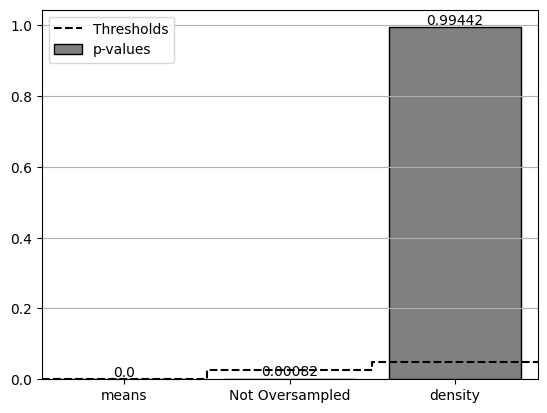

In [105]:
solvers = ["means", "density"]
fixed_params = {"k": 1, "dist_method": "euclidean"}
df = benchmark(["./../../data/benchmarks/imb_IRLowerThan9/", "./../../data/benchmarks/imb_IRHigherThan9p1/", "./../../data/benchmarks/imb_IRHigherThan9p2/"], "solver", solvers, fixed_params, progress=True)

In [106]:
solvers = ["Not Oversampled"] + solvers
means_total = df.iloc[:, 1:].mean(axis=0)
print("Max mean of F1 scores: ", means_total.max(), 
      "Solver: ", solvers[means_total.argmax()])

lower_means = df.iloc[0:22, 1:].mean(axis=0)
higher_means = df.iloc[22:, 1:].mean(axis=0)

lower_means_row = pd.DataFrame([['Lower_Means'] + lower_means.tolist()], columns=df.columns)
higher_means_row = pd.DataFrame([['Higher_Means'] + higher_means.tolist()], columns=df.columns)
means_total_row = pd.DataFrame([['Total_Means'] + means_total.tolist()], columns=df.columns)

df_with_means = pd.concat([df, lower_means_row, higher_means_row, means_total_row], ignore_index=True)

df_with_means_color = df_with_means.style.apply(highlight_max, axis=1)
df_with_means_color

Max mean of F1 scores:  0.6609054004517978 Solver:  density


,dataset,Not Oversampled,means,density
0,ecoli-0_vs_1,0.989944,0.989944,0.986307
1,ecoli1,0.830098,0.813847,0.826854
2,ecoli2,0.898502,0.882729,0.859731
3,ecoli3,0.626316,0.636597,0.623834
4,glass-0-1-2-3_vs_4-5-6,0.816279,0.885024,0.852692
5,glass0,0.641856,0.689433,0.709265
6,glass1,0.677032,0.749315,0.697472
7,glass6,0.801119,0.813846,0.779814
8,haberman,0.271926,0.436885,0.430245
9,iris0,1.000000,1.000000,1.000000
